# Session 15: Pivot tables. Merge, join, and concat.


## Pivot tables

Just like with Excel, we can use a similar set of operations to be performed on our dataframes:

The syntax for pivot tables in `pandas` is the following:

```Python
pd.pivot_table(
    data="our dataframe",
    values="column to aggregate",
    index="column to use as index",
    columns="column with categories with which to aggregate",
    aggfunc="function to use",
)
```

Let's see it with an example!

In [33]:
import pandas as pd

energy = pd.read_csv("../files/energy.csv")

energy.head()

,datetime,power_demand,nuclear,gas,solar,hydro,coal,wind,spot_price,year,month,day,hour,weekday
0,2018-12-31 23:00:00+00:00,23251.2,6059.2,2954.0,7.1,3202.8,1867.0,3830.3,66.88,2018,12,31,23,0
1,2019-01-01 00:00:00+00:00,22485.0,6059.2,3044.1,8.0,2884.4,1618.0,3172.1,66.88,2019,1,1,0,1
2,2019-01-01 01:00:00+00:00,20977.0,6059.2,3138.6,7.5,1950.8,1535.3,2980.5,66.00,2019,1,1,1,1
3,2019-01-01 02:00:00+00:00,19754.2,6059.2,3596.2,7.5,1675.7,1344.0,2840.0,63.64,2019,1,1,2,1
4,2019-01-01 03:00:00+00:00,19320.6,6063.4,3192.6,7.5,1581.8,1345.0,3253.4,58.85,2019,1,1,3,1


<Axes: xlabel='hour', ylabel='month'>

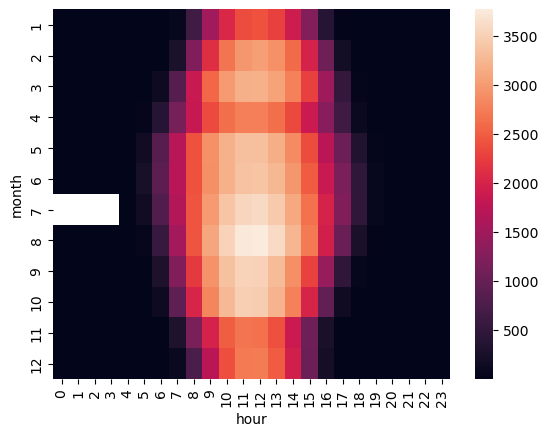

In [34]:
# Create a table with:
# months as rows -> `index`
# weekday as columns -> `columns`
# containing the average (`aggfunc`) solar power (`values`) per weekday and month
pt = pd.pivot_table(
    data=energy, 
    values="solar",
    index="month",
    columns="weekday",
    aggfunc="mean"
)

pt

In [36]:
energy.groupby(["month", "weekday"])[["solar"]].mean()

solar
month weekday             
1     0        1176.332759
      1         885.727848
      2         848.296341
      3         882.874286
      4        1054.105000
...                    ...
12    2         775.440476
      3         618.424419
      4         680.612941
      5         785.815909
      6         860.047423

[84 rows x 1 columns]

In [35]:
# to check let's calculate the average solar power generation 
# on Sundays in December
energy[
    (energy["weekday"]==6) &
    (energy["month"]==12)
]["solar"].mean()

# nice!

860.0474226804124

In the end, `pd.pivot_table` is nothing but filling a table with:

```Python
for idx in index:
    for category in column:
        table[idx, category] = df[
            (df[index]==idx) &
            (df[column]==category)
        ][values].aggfunc()
```

In [37]:
# Create a table with months and weekdays as rows
# containing the average solar power per weekday and month
pd.pivot_table(
    data=energy, 
    values="solar",
    index=["weekday", "month"],
    aggfunc="mean"
)

solar
weekday month             
0       1      1176.332759
        2      1163.607463
        3      1409.240000
        4      1238.181395
        5      1726.642254
...                    ...
6       8      1955.343077
        9      1484.169231
        10     1434.127778
        11      894.848649
        12      860.047423

[84 rows x 1 columns]

### Summarizing data

Pivot tables allow us to summarize data: 
* Create a table expressing the probability of having low/high wind in day of the week

In [81]:
if condition:
    do this
else:
    do this other thing
    

np.where(
    condition,
    do this,
    do this other thing
)

SyntaxError: invalid syntax (1514108982.py, line 2)

In [ ]:
np.size, np.sum, np.mean

def dadada():
    return something

In [38]:
# create categories of low/high wind
import numpy as np

energy["wind_cat"] = np.where(
    energy["wind"] > energy["wind"].mean(),
    "High",
    "Low"
)

# create table 
energy.pivot_table(
    index="weekday", 
    columns="wind_cat", 
    aggfunc="size",
)

wind_cat,High,Low
weekday,,
0,543,706
1,519,729
2,585,663
3,543,705
4,473,775
5,472,776
6,540,708


In [9]:
# we convert times into probabilities by dividing by the length of the df!

df = energy.pivot_table(
    index="weekday", columns="wind_cat", aggfunc="size",
) / len(energy)

df

wind_cat,High,Low
weekday,,
0,0.062149,0.080806
1,0.059403,0.083438
2,0.066957,0.075884
3,0.062149,0.080691
4,0.054138,0.088703
5,0.054023,0.088818
6,0.061806,0.081035


In [10]:
df.values.sum()

1.0

In [11]:
# Calculate the probabilities of having low/high wind for both weekdays and hours

energy.pivot_table(
    index=["weekday", "hour"],
    columns="wind_cat", 
    aggfunc="size",
) / len(energy)

wind_cat          High       Low
weekday hour                    
0       0     0.002747  0.003205
        1     0.002861  0.003090
        2     0.002632  0.003319
        3     0.002518  0.003434
        4     0.002518  0.003434
...                ...       ...
6       19    0.003090  0.002861
        20    0.003319  0.002632
        21    0.003205  0.002747
        22    0.003090  0.002861
        23    0.002747  0.003205

[168 rows x 2 columns]

### `stack` and `unstack`

We can use `stack` and `unstack` to transform a dataframe from a wide format to a long format and viceversa.

It is important to note that `stack` and `unstack` are not methods of the dataframe, but of the `MultiIndex` object.

These methods allow us to "move" labels from rows to columns and viceversa
* `unstack` moves row labels to column labels
* `stack` moves column labels to row labels

By default, the level at which these function operates is on the -1th level.

In [12]:
# create DF with 2 indices
df = energy.groupby(["month", "weekday"]).agg({
    "coal": ["sum", "mean"],
    "wind": ["sum", "mean"]
})

df

coal                    wind              
                    sum         mean        sum          mean
month weekday                                                
1     0        421269.8  4388.227083   824014.0   8583.479167
      1        507610.3  4230.085833   846574.9   7054.790833
      2        512002.1  4266.684167  1127327.0   9394.391667
      3        499262.3  4160.519167  1107441.0   9228.675000
      4        456063.6  4750.662500   604727.5   6299.244792
...                 ...          ...        ...           ...
12    2         57690.3   801.254167   687588.4   7162.379167
      3         60719.6   645.953191   966697.5  10069.765625
      4         49367.6   530.834409   843487.3   8786.326042
      5         31480.4   655.841667   675993.2   7041.595833
      6         51225.7   683.009333   759838.7   6331.989167

[84 rows x 4 columns]

In [13]:
# move `weekday` from rows to columns: unstack weekday
energy.groupby(["month", "weekday"]).agg({
    "coal": ["sum", "mean"],
    "wind": ["sum", "mean"]
}).unstack(level="weekday")

coal                                                              \
              sum                                                               
weekday         0         1         2         3         4         5         6   
month                                                                           
1        421269.8  507610.3  512002.1  499262.3  456063.6  403004.1  299088.4   
2        355023.1  412356.6  409794.9  354202.2  296157.4  228108.9  201911.1   
3         90575.2   93075.8   83690.6  115528.7  211058.3  136452.7  105241.6   
4        143198.9  141308.6   93011.4   93500.1   97725.8   86918.0   75626.0   
5         46014.0   57783.7   67651.7   65313.1   54077.2   34526.5   34845.2   
6         60259.3   69456.2   65415.9   57449.5   53481.9   58768.7   65776.0   
7        103709.9  120206.6  126196.5  102481.9  102255.1   59825.4   54971.8   
8         39654.1   47677.5   49256.2   68909.5   68596.1   54148.6   35596.5   
9         87533.4   74152.3   73621.4   63098.8   62168.6   42217.6   57211.7   
10       100779.0  133426.4  127907.2  116723.8   78866.9   64727.8   65093.0   
11        70592.7   85964.6  101457.7  103385.3   82449.8   69183.2   50649.2   
12        78784.7   66524.0   57690.3   60719.6   49367.6   31480.4   51225.7   

                                                ...       wind             \
                mean                            ...        sum              
weekday            0            1            2  ...          4          5   
month                                           ...                         
1        4388.227083  4230.085833  4266.684167  ...   604727.5   547692.5   
2        3698.157292  4295.381250  4268.696875  ...   687880.1   742590.4   
3         943.491667   969.539583   871.777083  ...   479457.2   509594.6   
4        1193.324167  1177.571667   968.868750  ...   688169.6   654563.4   
5         479.312500   601.913542   563.764167  ...   873835.7   631901.0   
6         627.701042   723.502083   681.415625  ...   449544.9   414505.6   
7         864.249167  1001.721667  1051.637500  ...   315439.9   438007.4   
8         413.063542   496.640625   513.085417  ...   437170.9   334951.0   
9         729.445000   772.419792   766.889583  ...   577429.3   548192.7   
10       1049.781250  1111.886667  1065.893333  ...   397112.2   492724.4   
11        735.340625   895.464583  1056.851042  ...  1222601.3  1281275.4   
12        667.666949   923.944444   801.254167  ...   843487.3   675993.2   

                                                                          \
                            mean                                           
weekday          6             0            1            2             3   
month                                                                      
1         845505.9   8583.479167  7054.790833  9394.391667   9228.675000   
2         709697.2   4573.125000  3127.797917  3264.470833   4621.850000   
3         710068.8   7840.760417  8366.327083  9745.963542   6416.372917   
4         540527.0   4688.543333  5507.959167  9419.402083   7540.681250   
5         625664.3   4705.531250  5094.652083  6217.274167   6080.860000   
6         425935.3   3330.016667  5273.940625  5041.561458   5647.368750   
7         383020.7   5041.106667  4705.435833  4125.745000   3559.652083   
8         385160.3   4416.210417  3737.441667  3280.898958   3903.412500   
9         590555.9   4250.530833  5994.954167  5176.195833   5125.916667   
10        444821.8   4660.223958  5447.506667  5343.123333   5583.927500   
11       1143600.5  10425.447917  9691.090625  9423.719792   9903.391667   
12        759838.7   7981.160331  5662.886458  7162.379167  10069.765625   

                                                   
                                                   
weekday             4             5             6  
month                                              
1         6299.244792   5705.130208   8807.353125  
2     

In [14]:
# move ("coal", "wind") from columns labels to rows: stack 0
energy.groupby(["month", "weekday"]).agg({
    "coal": ["sum", "mean"],
    "wind": ["sum", "mean"]
}).stack(0)

mean       sum
month weekday                            
1     0       coal  4388.227083  421269.8
              wind  8583.479167  824014.0
      1       coal  4230.085833  507610.3
              wind  7054.790833  846574.9
      2       coal  4266.684167  512002.1
...                         ...       ...
12    4       wind  8786.326042  843487.3
      5       coal   655.841667   31480.4
              wind  7041.595833  675993.2
      6       coal   683.009333   51225.7
              wind  6331.989167  759838.7

[168 rows x 2 columns]

## Merge, join and concat.

* `pd.join`: database-style join operation on the `index` labels of both dataframes
* `pd.merge`: like `pd.join` but extending functionalities
* `pd.concat`: puts together dataframes on the vertical (axis=0) or horizontal (axis=1)

### Merge

In [15]:
df_left = pd.DataFrame({
    "date": ["2020-01-01", "2020-01-01", "2020-01-02", "2020-01-02"],
    "hour": [1, 2, 1, 3],
    "price": [50, 51, 45, 47]
})

df_right = pd.DataFrame({
    "date": ["2020-01-01", "2020-01-01", "2020-01-02", "2020-01-02"],
    "hour": [3, 2, 1, 2],
    "sales": [46, 45, 15, 16]
})

In [16]:
df_left

,date,hour,price
0,2020-01-01,1,50
1,2020-01-01,2,51
2,2020-01-02,1,45
3,2020-01-02,3,47


In [17]:
df_right

,date,hour,sales
0,2020-01-01,3,46
1,2020-01-01,2,45
2,2020-01-02,1,15
3,2020-01-02,2,16


In [18]:
"""
select
    df_left.date,
    df_left.hour,
    df_left.price,
    df_right.sales
from df_left
outer join on
    df_left.date=df_right.date and df_left.hour=df_right.hour
"""


# outer join
pd.merge(df_left, df_right, on=["date", "hour"], how="outer")

,date,hour,price,sales
0,2020-01-01,1,50.0,NaN
1,2020-01-01,2,51.0,45.0
2,2020-01-02,1,45.0,15.0
3,2020-01-02,3,47.0,NaN
4,2020-01-01,3,NaN,46.0
5,2020-01-02,2,NaN,16.0


In [19]:
"""
select
    df_left.date,
    df_left.hour,
    df_left.price,
    df_right.sales
from df_left
left join on
    df_left.date=df_right.date and df_left.hour=df_right.hour
"""

# left join
pd.merge(df_left, df_right, on=["date", "hour"], how="left")

,date,hour,price,sales
0,2020-01-01,1,50,NaN
1,2020-01-01,2,51,45.0
2,2020-01-02,1,45,15.0
3,2020-01-02,3,47,NaN


In [20]:
"""
select
    df_left.date,
    df_left.hour,
    df_left.price,
    df_right.sales
from df_left
right join on
    df_left.date=df_right.date and df_left.hour=df_right.hour
"""

# right join
pd.merge(df_left, df_right, on=["date", "hour"], how="right")

,date,hour,price,sales
0,2020-01-01,3,NaN,46
1,2020-01-01,2,51.0,45
2,2020-01-02,1,45.0,15
3,2020-01-02,2,NaN,16


In [21]:
"""
select
    df_left.date,
    df_left.hour,
    df_left.price,
    df_right.sales
from df_left
inner join on
    df_left.date=df_right.date and df_left.hour=df_right.hour
"""

# inner join
pd.merge(df_left, df_right, on=["date", "hour"], how="inner")

,date,hour,price,sales
0,2020-01-01,2,51,45
1,2020-01-02,1,45,15


In [22]:
# performing merge on several dataframes
df_extra = pd.DataFrame({
    "date": ["2020-01-01", "2020-01-01", "2020-01-02", "2020-01-02"],
    "hour": [1, 2, 1, 3],
    "temp": [17, 28, 4, 16]
})

# create list of dataframes to merge
dfs = [df_left, df_right, df_extra]

# using reduce from functools
from functools import reduce

reduce(
    lambda left, right: pd.merge(left, right, on=["date", "hour"], how="left"), 
    dfs
)

,date,hour,price,sales,temp
0,2020-01-01,1,50,NaN,17
1,2020-01-01,2,51,45.0,28
2,2020-01-02,1,45,15.0,4
3,2020-01-02,3,47,NaN,16


### Concat

In [23]:
df1 = pd.DataFrame(
    data={
        "val1": [1, 2, 3],
        "val2": ["H", "J", "K"]
    },
    index=["a", "b", "c"]
)

df2 = pd.DataFrame(
    data={
        "val1": [5, 6, 7],
        "val2": ["L", "M", "N"]
    },
    index=["e", "g", "i"]
)

df3 = pd.DataFrame(
    data={
        "val3": [5, 6, 7],
        "val4": ["L", "M", "N"]
    },
    index=["a", "b", "c"]
)

In [24]:
df1

,val1,val2
a,1,H
b,2,J
c,3,K


In [25]:
df2

,val1,val2
e,5,L
g,6,M
i,7,N


In [26]:
df3

,val3,val4
a,5,L
b,6,M
c,7,N


In [27]:
# with same names of columns
pd.concat([df1, df2])

,val1,val2
a,1,H
b,2,J
c,3,K
e,5,L
g,6,M
i,7,N


# by default, axis=0
pd.concat([df1, df3])

In [28]:
# concat on axis=1 (horizontally) 

# with same index
pd.concat([df1, df3], axis=1)

,val1,val2,val3,val4
a,1,H,5,L
b,2,J,6,M
c,3,K,7,N


In [30]:
# with different index
df2.index = ["x", "y", "z"]

pd.concat([df1, df2], axis=1, sort=False)

,val1,val2,val1,val2
a,1.0,H,NaN,NaN
b,2.0,J,NaN,NaN
c,3.0,K,NaN,NaN
x,NaN,NaN,5.0,L
y,NaN,NaN,6.0,M
z,NaN,NaN,7.0,N


## Practice

### Exercise 1:
Load all the `animals_YYYY.csv` datasets into a single dataframe called `animals`.

Create an extra column on each DF representing the year from the name.

In [32]:
import os

animals_files = []

for file in os.listdir("../files"):
    if "animals_" in file:
        df = pd.read_csv(f"../files/{file}")
        df["year"] = int(file.split("_")[1].split(".")[0])
        animals_files.append(df)
    
animals = pd.concat(animals_files)

animals
    


,year,area,dogs,cats
0,2016,ARGANZUELA,10591,3202
1,2016,BARAJAS,5173,981
2,2016,CARABANCHEL,19275,3728
3,2016,CENTRO,15470,6164
4,2016,CHAMARTÍN,11759,2809
...,...,...,...,...
16,2018,TETUÁN,12478,4763
17,2018,USERA,12475,2419
18,2018,VICÁLVARO,5393,1279
19,2018,VILLA DE VALLECAS,9857,2467


### Exercise 2:
Create a table with average number of dogs and cats per area for the period 2015-2017

In [99]:
pd.pivot_table(
    data=animals[(animals["year"]>=2015) & (animals["year"]<=2017)],
    index="area",
    values=["dogs", "cats"],    
    aggfunc="mean"
)

,cats,dogs
area,,
ARGANZUELA,2936.333333,10396.000000
BARAJAS,902.666667,5220.000000
CARABANCHEL,3462.666667,19090.000000
CENTRO,5485.333333,14916.666667
CHAMARTÍN,2597.333333,12270.666667
CHAMBERÍ,2780.666667,13813.666667
CIUDAD LINEAL,5413.000000,17746.333333
FUENCARRAL-EL PARDO,3954.333333,18194.000000
HORTALEZA,5958.333333,16632.333333


### Exercise 3:
With the dataset `parks_and_extension.csv`, 
calculate the total extension of parks per area and sort them from highest to lowest.
* Check the formats!

In [101]:
parks = pd.read_csv("../files/parks_and_extension.csv", decimal=",")       
parks.sort_values("extension", ascending=False)

,area_code,area,park_name,extension
44,12,USERA,PARQUE DE PRADOLONGO,59.51
41,10,LATINA,PARQUE DE LAS CRUCES,45.15
6,2,ARGANZUELA,PARQUE ENRIQUE TIERNO GALVÁN,40.06
46,13,PUENTE DE VALLECAS,PARQUE LINEAL DE PALOMERAS,39.55
68,19,VICÁLVARO,Z.F. ANILLO VERDE DE VICÁLVARO,31.31
...,...,...,...,...
4,1,CENTRO,PARQUE DE LA DALIEDA DE S.FCO EL GRANDE,0.43
17,4,SALAMANCA,BULEVAR DE JUAN BRAVO,0.38
13,4,SALAMANCA,PLAZA DE LA INDEPENDENCIA-PUERTA DE ALCALÁ,0.31
63,18,VILLA DE VALLECAS,PASEO FEDERICO GARCÍA LORCA,0.24


In [102]:

total_extension_per_area = pd.pivot_table(
    parks,
    index="area",
    values="extension",
    aggfunc="sum"
).sort_values(by="extension", ascending=False)

total_extension_per_area

,extension
area,
LATINA,79.04
VICÁLVARO,72.55
PUENTE DE VALLECAS,72.31
USERA,63.99
ARGANZUELA,44.84
HORTALEZA,42.30
FUENCARRAL - EL PARDO,39.94
TETUÁN,37.65
CIUDAD LINEAL,33.10


### Exercise 4:
What's the area with the most parks?

In [107]:
pd.pivot_table(
    parks,
    index="area",
    values="extension",
    aggfunc="count"
).sort_values(by="extension", ascending=False)

,extension
area,
SALAMANCA,7
HORTALEZA,5
CHAMBERÍ,5
SAN BLAS - CANILLEJAS,5
VICÁLVARO,5
TETUÁN,5
CENTRO,5
CIUDAD LINEAL,4
FUENCARRAL - EL PARDO,4


### Exercise 5:
What's the area with the biggest parks (on average)?

In [106]:
avg_extension_per_area = pd.pivot_table(
    parks,
    index="area",
    values="extension",
    aggfunc="mean"
).sort_values(by="extension", ascending=False)

avg_extension_per_area#["extension"].idxmax()

,extension
area,
USERA,31.995000
CARABANCHEL,26.060000
LATINA,19.760000
PUENTE DE VALLECAS,18.077500
ARGANZUELA,14.946667
VICÁLVARO,14.510000
FUENCARRAL - EL PARDO,9.985000
HORTALEZA,8.460000
CIUDAD LINEAL,8.275000
